In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.spatial import distance as dist
%matplotlib inline

In [3]:
im_reg = cv2.imread('D:\\ShachiLab\\Mukul\\Registration_matlab\\results\\registered\\rad_625_04_iter_500_time_4294.tif')
im_ir =  cv2.imread('D:\\ShachiLab\\Mukul\\Registration_matlab\\results\\registered\\fixed_resized.png')

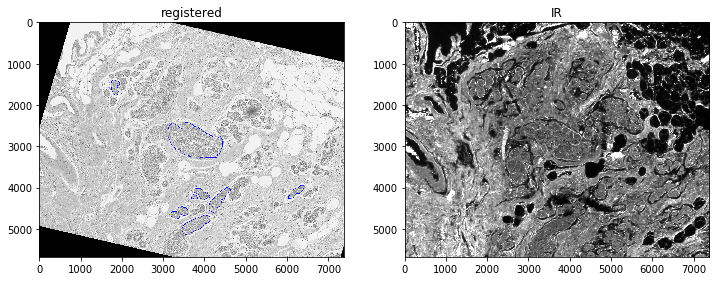

In [4]:
plt.figure(figsize = (12,12))
plt.subplot(1,2,1)
plt.title('registered')
plt.imshow(im_reg, cmap = 'gray')
plt.subplot(1,2,2)
plt.title('IR')
plt.imshow(im_ir, cmap = 'gray')

In [5]:
cnt_pos = np.where(im_reg[:,:,2] == 255)
print(np.array(cnt_pos).shape)

(2, 118436)


In [6]:
cord_list = [] #list of the coordinates
for a, b in zip(cnt_pos[0], cnt_pos[1]):
    cord_list.append([a,b])

In [7]:
cnt_pos

(array([1393, 1393, 1393, ..., 5149, 5149, 5149], dtype=int64),
 array([1810, 1811, 1812, ..., 3624, 3625, 3626], dtype=int64))

In [8]:
im_reg_gray = cv2.cvtColor(im_reg, cv2.COLOR_BGR2GRAY)
M1 = np.zeros_like(im_reg_gray)

In [9]:
x, y = zip(*cord_list)

In [10]:
x1 = list(cnt_pos[0])
x2 = list(cnt_pos[1])
M1[x1,x2] = 255

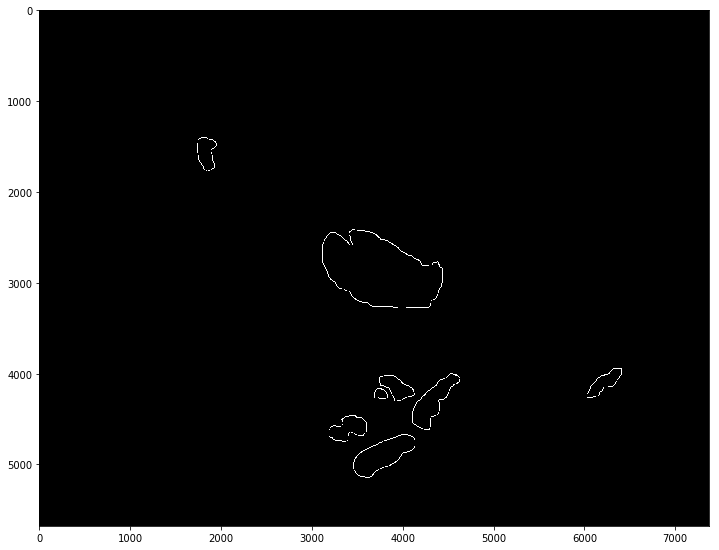

In [11]:
plt.figure(figsize = (12,12))
plt.imshow(M1, cmap = 'gray')
plt.show()

In [12]:
cntrs, _ = cv2.findContours(M1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [13]:
np.array(cntrs).shape

(8,)

In [14]:
direct = "D:\\ShachiLab\\Mukul\\Registration_matlab\\results\\registered\\post_process\\roi_test"

In [15]:
# Didn't work for M[6], don't use fillConvexPoly, perhaps it's not able to fill some concave region
M = []
idx = 24
for cnt in cntrs:
    M3 = np.zeros_like(im_reg_gray)
    #filename = os.path.join(direct, str(idx) + ".png")
    cv2.drawContours(M3, cnt, -1, (255,255,255),15)
    M.append(cv2.fillConvexPoly(M3, cnt, 255))
    #cv2.imwrite(filename, M3)
    idx += 1

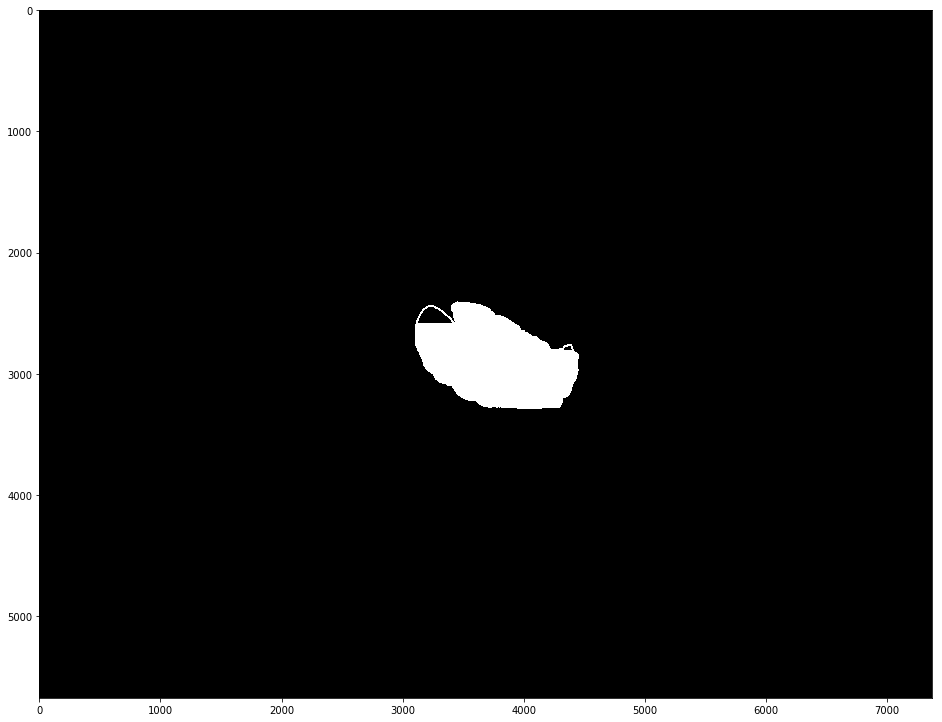

In [16]:
plt.figure(figsize = (16,16))
plt.imshow(M[6], cmap = 'gray')

In [17]:
# this method worked
# TODO - Try to find out difference between fillPoly, and fillConvexPoly and drawContours with flag FILLED
#cv2.drawContours also didn't work
M6 = []
idx = 32
for cnt in cntrs:
    M3 = np.zeros_like(im_reg_gray)
    filename = os.path.join(direct, str(idx) + ".png")
    #cv2.drawContours(M3, cnt, -1, (255,255,255),thickness = cv2.FILLED)
    cv2.fillPoly(M3, [cnt], (255,255,255))
    M6.append(M3)
    cv2.imwrite(filename, M3)
    idx += 1

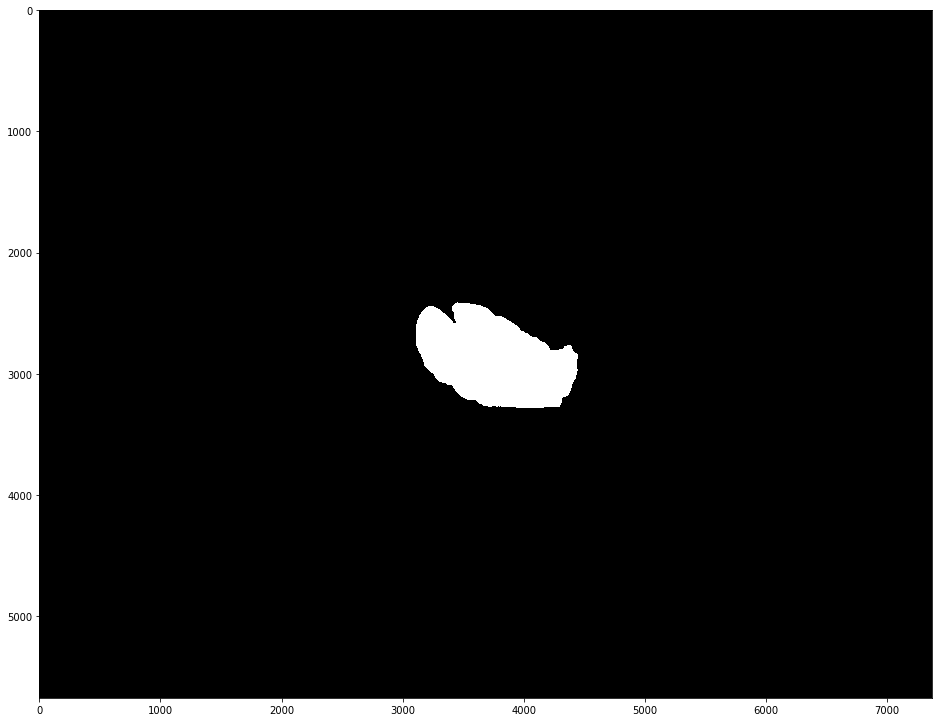

In [18]:
plt.figure(figsize = (16,16))
plt.imshow(M6[6], cmap = 'gray')

## Crop the images from registered and IR image to compare

In [19]:
#x, y, w, h = cv2.boundingRect(cnt)
reg1 = cv2.imread('D:\\ShachiLab\\Mukul\\Registration_matlab\\results\\registered\\reg_final.tif')

In [20]:
im_ir.shape

(5677, 7372, 3)

In [21]:
R = []
IR = []
reg_gray = cv2.cvtColor(reg1, cv2.COLOR_BGR2GRAY)
ir_gray = cv2.cvtColor(im_ir, cv2.COLOR_BGR2GRAY)
for im in M6:
    R1 = cv2.bitwise_and(reg_gray,im)
    IR1 = cv2.bitwise_and(ir_gray, im)
    R.append(R1)
    IR.append(IR1)

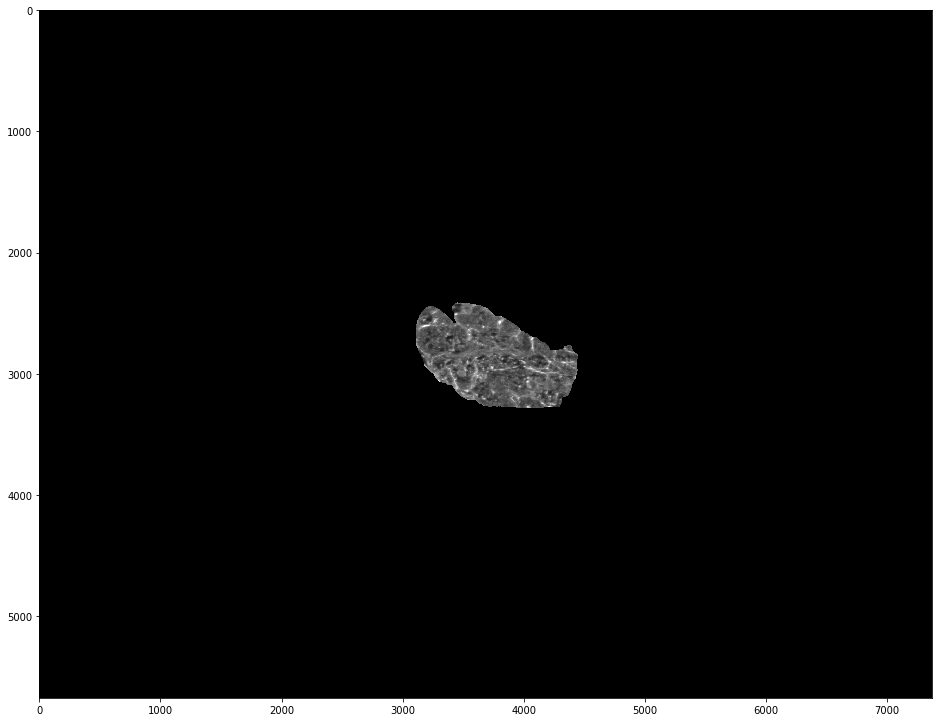

In [22]:
plt.figure(figsize = (16,16))
plt.imshow(IR[6], cmap = 'gray')

In [28]:
path1 = 'D:\\ShachiLab\\Mukul\\Registration_matlab\\results\\registered\\compare'

In [24]:
i = 0
P_reg = [] # registered patches
P_ir = [] # ir image patches
for cnt in cntrs:
    x, y, w, h = cv2.boundingRect(cnt)
    f1 = os.path.join(path1, str(i) + "reg.png")
    f2 = os.path.join(path1, str(i) + "ir.png")
    reg = R[i][y:y+h, x:x+w]
    
    
    P_reg.append(reg)
    ir = IR[i][y:y+h, x:x+w]
    P_ir.append(ir)
    #cv2.imwrite(f1, reg)
    #cv2.imwrite(f2, ir)
    i += 1

## Set the threshold using histogram matching
### OpenCV Methods

In [62]:
h_ir = []
h_reg = []
for r, i in zip(P_reg, P_ir):
    #r1 = cv2.bitwise_not(r)
    h1 = cv2.calcHist(r, [0], None, [256], [0,256])
    h1 = cv2.normalize(h1, h1).flatten()
    h_reg.append(h1)
    
    #i1 = cv2.bitwise_not(r)
    h11 = cv2.calcHist(i, [0], None, [256], [0,256])
    h11 = cv2.normalize(h11, h11).flatten()
    h_ir.append(h11)

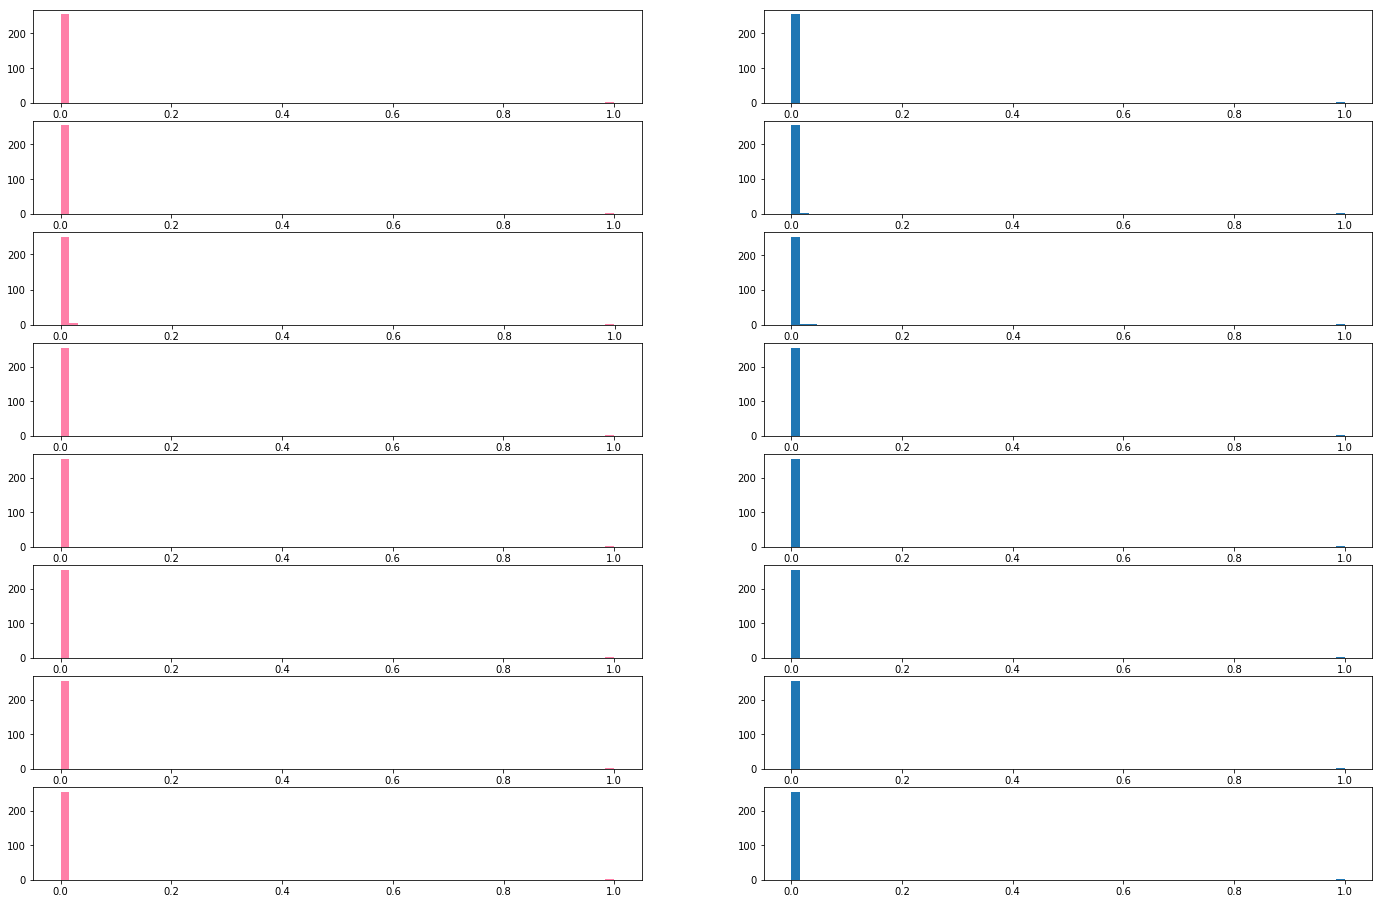

In [64]:
results = []
i = 1
plt.figure(figsize = (24,16))
for h1, h2 in zip(h_ir, h_reg):
    plt.subplot(8,2,i)
    plt.hist(h1, bins = 64, color = '#ff7fa7')
    i+=1
    plt.subplot(8,2,i)
    plt.hist(h2, bins = 64)
    i+=1

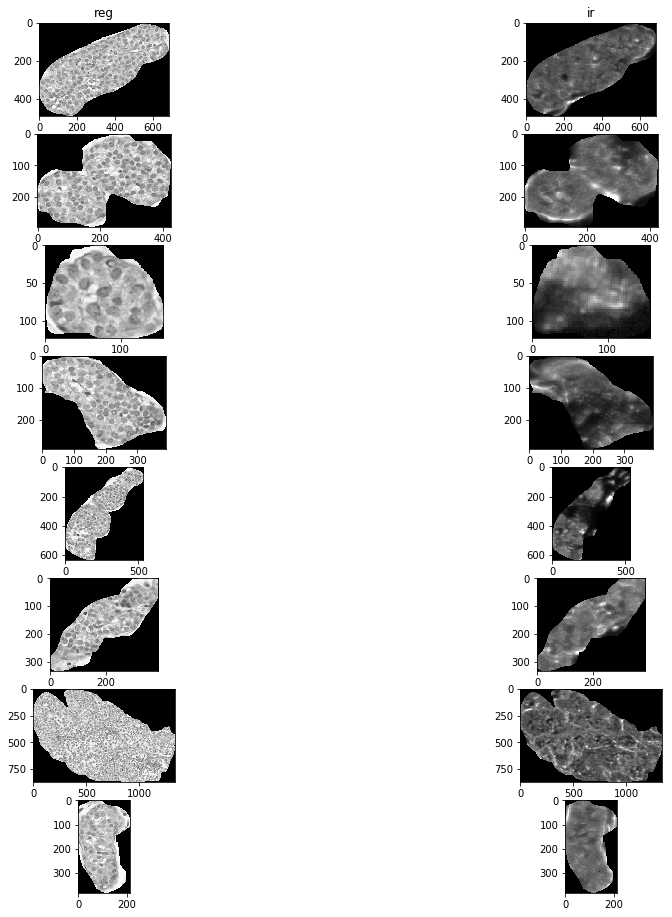

In [61]:
idx = 1
plt.figure(figsize = (16,16))
for r, i in zip(P_reg, P_ir):
    plt.subplot(8,2,idx)
    if(idx == 1):
        plt.title('reg')
    plt.imshow(r, cmap = 'gray')
    idx+=1
    plt.subplot(8,2,idx)
    if(idx == 2):
        plt.title('ir')
    plt.imshow(i, cmap = 'gray')
    idx+=1

In [74]:
i = 0
methods = [cv2.HISTCMP_CORREL, cv2.HISTCMP_CHISQR, cv2.HISTCMP_INTERSECT, cv2.HISTCMP_BHATTACHARYYA ]
# cv2.HISTCMP_CHISQR and cv2.HISTCMP_BHATTACHARYYA -  minimum is the better other two reverse
results = [ [] for i in range(len(methods)) ]
for method in methods:
    for h1, h2 in zip(h_ir, h_reg):
        d = cv2.compareHist(h1, h2, method)
        results[i].append(d)
    i += 1
res_arr = np.array(results)
print(res_arr)

[[0.99997619 0.99929551 0.99794065 0.99993262 0.99988255 0.99990368
  0.99998915 0.99976797]
 [0.00734204 0.05954097 0.09779695 0.0129528  0.01720769 0.01570584
  0.00678729 0.02403486]
 [0.99998593 0.99950778 0.99892592 0.99995637 0.99992502 0.99993837
  0.99999344 0.9998498 ]
 [0.08537347 0.23707823 0.29861677 0.11308282 0.1300665  0.124354
  0.08210708 0.15321285]]


### Scipy Methods

In [75]:
i = 0
sc_methods = [dist.euclidean, dist.cityblock, dist.chebyshev]# in all three minimum is better
results_sc = [ [] for i in range(len(sc_methods)) ]
for method in sc_methods:
    for h1, h2 in zip(h_ir, h_reg):
        d = method(h1, h2)
        results_sc[i].append(d)
    i += 1
res_arr_sc = np.array(results_sc)
print(res_arr_sc)

[[0.00688746 0.03745395 0.06402618 0.01158544 0.01529544 0.01385141
  0.00464885 0.02149806]
 [0.01468846 0.11934787 0.19570088 0.02592601 0.03444777 0.03143952
  0.01357691 0.04814063]
 [0.00440522 0.02480168 0.03493089 0.00777168 0.00955951 0.00785292
  0.00226243 0.01442091]]


### Modified Chi Squared distance

In [76]:
def chi2_distance(histA, histB, eps = 1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])
    # return the chi-squared distance
    return d

In [77]:
res1 = []
for h1, h2 in zip(h_ir, h_reg):
    d = chi2_distance(h1, h2)
    res1.append(d)
res1_arr = np.array(res1)
print(res1_arr)

[0.00734206 0.05953248 0.09780171 0.01295293 0.01720741 0.01570605
 0.00678729 0.02403568]


## Set the threshold using cnn features embedding similarity

## Extra Work

In [26]:
equ = cv2.equalizeHist(ir_gray)
#res = np.hstack((ir_gray,equ)) #stacking images side-by-side
f11 = os.path.join(path1, str(i) + "ir_equalized.png")
cv2.imwrite(f11, equ)

True

In [27]:
equ1 = cv2.bitwise_not(equ)
f12 = os.path.join(path1, "ir_not_equalized.png")
cv2.imwrite(f12, equ1)

True

In [47]:
I = cv2.imread('E:\\Mukul\\others\\stof.png')
I.shape

(701, 1250, 3)

In [48]:
I_cnt = np.where(I[:,:,2] == 255)
I_mask = np.zeros_like(I[:,:,2])

In [59]:
I_cnt

(array([197, 197, 197, ..., 474, 474, 474], dtype=int64),
 array([987, 988, 989, ..., 467, 468, 469], dtype=int64))

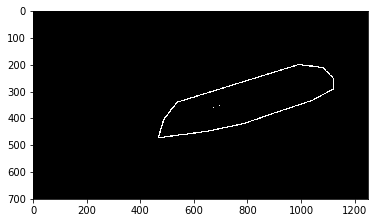

In [50]:
I_mask[list(I_cnt[0]), list(I_cnt[1])] = 255
plt.imshow(I_mask, cmap = 'gray')

In [54]:
I_cnt1, _ = cv2.findContours(I_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
np.array(I_cnt1)

array([[[[987, 197]],

        [[986, 198]],

        [[985, 199]],

        ...,

        [[990, 197]],

        [[989, 197]],

        [[988, 197]]]], dtype=int32)

In [60]:
np.array(I_cnt1).shape

(1, 1420, 1, 2)

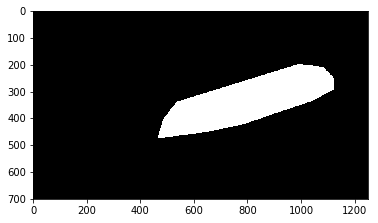

In [56]:
cv2.fillConvexPoly(I_mask, I_cnt1[0], 255)
plt.imshow(I_mask,cmap = 'gray')

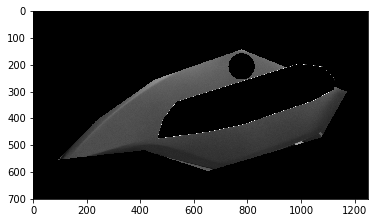

In [58]:
I_mask1 = cv2.bitwise_not(I_mask)
out = cv2.bitwise_and(I_mask1, I[:,:,2])
plt.imshow(out,cmap = 'gray')

In [66]:
temp_list = []
for a, b in zip(I_cnt[0], I_cnt[1]):
    temp_list.append([b, a])

In [67]:
ctr = np.array(temp_list).reshape((-1,1,2)).astype(np.int32)

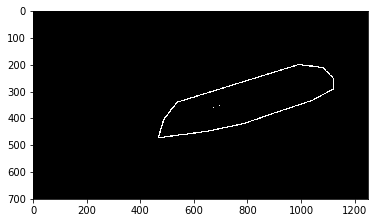

In [68]:
I_mask1 = np.zeros_like(I[:,:,2])
I_mask1[list(I_cnt[0]), list(I_cnt[1])] = 255
plt.imshow(I_mask1, cmap = 'gray')

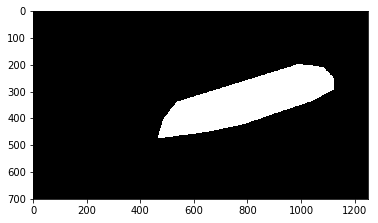

In [69]:
cv2.fillConvexPoly(I_mask1, ctr, 255)
plt.imshow(I_mask1,cmap = 'gray')